# SVD++ 

We implement a variation of the SVD++ algorithm proposed by Yehuda Koren. SVD++ computes the estimate for rating $r_{ui}$ as follows:

$$\hat{r}_{ui} = b_{ui} + q_i^T\Bigg(p_u + |N(u)|^{-\frac{1}{2}} \sum_{j\in N(U)} y_j \Bigg)$$

where $b_{ui}$ represent the bias of item $i$ for user $u$, and $\sum y_j$ represents the implicit feedback for user $u$.

We apply the following changes:

- add learning rate decay
- add momentum to the gradients
- use heuristics to initialize user biases, item biases, and users' implicit feedback as proposed by Zhengzheng Xian et al., instead of learning them in the optimization step

The decay and momentum are added to stabilize the optimization, while the heuristic initializations are needed to prevent prohibitive training times.

As a further way to speed-up the training process, we implement the optimization step in cython.

We call this algorithm **SVDPP2**, which stands for Singular Value Decomposition Plus Plus version 2, as opposed to version 1 where we learn the biases and the implicit feedback in the optimization.

### Importing the libraries and setting the random seed

In [1]:
# import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%pip install scikit-surprise
from surprise import AlgoBase, PredictionImpossible, Reader, Dataset, accuracy
from surprise.model_selection import train_test_split, cross_validate

# set the random seed for reproducibility
np.random.seed(0)

You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


### Prepare the dataset

First we read the dataset as a pandas DataFrame.

In [2]:
data_train_raw = pd.read_csv('../data/data-train.csv')

# parse rows and columns
row_str = data_train_raw['Id'].apply(lambda x: x.split('_')[0])
row_id = row_str.apply(lambda x: int(x.split('r')[1]) - 1)
col_str = data_train_raw['Id'].apply(lambda x: x.split('_')[1])
col_id = col_str.apply(lambda x: int(x.split('c')[1]) - 1)

# apply changes
data_train_raw['row'] = row_id
data_train_raw['col'] = col_id

# dataset as data frame
data_train_df = data_train_raw.loc[:,['row', 'col', 'Prediction']]

### Prepare training and test sets

Next we prepare the training and test sets by using the surprise package, based on the previously computed DataFrame.

In [3]:
# set up surprise dataset
reader = Reader()
dataset = Dataset.load_from_df(data_train_df[['row', 'col', 'Prediction']], reader)

# now set up training and test set, with a test split of 25%
trainset, testset = train_test_split(dataset, test_size=0.25)

### Wrapper class

To run algorithms using the surprise package, we need to create a wrapper class. This class must have the following structure:

```
class MySVDPP(Algobase):
    def __init__(self):
        AlgoBase.__init__(self)
    def fit(self, trainset):
        AlgoBase.fit(self, trainset)
        return self
    def estimate(self, u, i):
        return self.prediction[u,i]
```

In [4]:
class SVDPP2(AlgoBase):
    
    def __init__(self, sgd, get_heuristics, n_factors=10, n_epochs=5, init_mean=0, init_std=0.1, lr0_P=0.1, lr0_Q=0.1, alpha_P=0.1, alpha_Q=0.1, decay_P=0.1, decay_Q=0.1, reg_P=1, reg_Q=1, lambda_1=1, lambda_2=1, lambda_3=1):
        
        AlgoBase.__init__(self)
        
        self.sgd = sgd
        self.get_heuristics = get_heuristics
        self.n_factors = n_factors
        self.n_epochs = n_epochs
        self.init_mean = init_mean
        self.init_std = init_std
        self.lr0_P = lr0_P
        self.lr0_Q = lr0_Q
        self.alpha_P = alpha_P
        self.alpha_Q = alpha_Q
        self.decay_P = decay_P
        self.decay_Q = decay_Q
        self.reg_P = reg_P
        self.reg_Q = reg_Q
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.lambda_3 = lambda_3
        
    def fit(self, trainset):
        
        AlgoBase.fit(self, trainset)
        
        # compute the necessary heuristics
        self.mu, self.bias_u, self.bias_i, self.Y = self.get_heuristics(self.n_factors, self.lambda_1, self.lambda_2, self.lambda_3)
        
        # now perform SGD
        self.P, self.Q = self.sgd(self.trainset, testset, self.mu, self.bias_u, self.bias_i, self.Y, self.n_factors, self.n_epochs, self.init_mean, self.init_std, self.lr0_P, self.lr0_Q, self.alpha_P, self.alpha_Q, self.decay_P, self.decay_Q, self.reg_P, self.reg_Q)
        
    def estimate(self, u, i):
        
        # compute the estimate
        est = self.mu + self.bias_u[u] + self.bias_i[i] + np.dot(self.Q[i,:], self.P[u,:] + self.Y[u,:])
        
        # clip the estimate to fall within range
        est = np.clip(est, 1,5)
        
        return est

### Heuristic initialization

Now we initialize the user and item biases. Each entry $b_i$, $b_u$ is initialized as follows:

$$b_i = \frac{\sum_{u\in R(i)}(r_{ui}-\mu)}{\lambda_1 + |R(i)|}$$ \
$$b_u = \frac{\sum_{i\in R(u)}(r_{ui}-\mu-b_i)}{\lambda_2 + |R(u)|}$$

where $R(u)$ is the set of items rated by user $u$, and viceversa.

The implicit feedback for user $u$ is initialized as follows:

$$Y_u = \frac{1}{\sqrt{|R(u)|}}\cdot \frac{\sum_{i\in R(u)}V_i}{(\lambda_3 + |R(u)|)}$$

where $V \in \mathbb{R}^{items\times factors}$ is the items-to-factors matrix obtained from SVD. Note that for this step we do not impute the ratings matrix.

In [5]:
def get_heuristics(n_factors, lambda_1, lambda_2, lambda_3):
    '''
    Compute the global mean, users' biases, items' biases, and users' implicit feedback.
    
    Parameters:
    n_factors (int): the number of latent factors
    lambda_1 (float): the regularization strenght for the initialization of the item biases
    lambda_2 (float): the regularization strenght for the initialization of the user biases
    lambda_3 (float): the regularization strenght for the initialization of the user implicit feedback
    
    Returns:
    mu, bias_u, bias_i, Y (float, numpy.ndarray, numpy.ndarray, numpy.ndarray): the computed heuristics
    '''
    
    print('Computing heuristics...')

    # get global mean
    mu = trainset.global_mean

    # initialize the biases vectors
    bias_u = np.zeros(trainset.n_users)
    bias_i = np.zeros(trainset.n_items)

    # items biases
    for i in range(trainset.n_items):
        neigh_i = trainset.ir[i] # neighborhood for item i
        for u, r in neigh_i:
            bias_i[i] += r - mu
        bias_i[i] /= (lambda_1 + len(neigh_i))

    # users biases
    for u in range(trainset.n_users):
        neigh_u = trainset.ur[u] # neighborhood for item u
        for i, r in neigh_u:
            bias_u[u] += r - mu - bias_i[i]
        bias_u[u] /= (lambda_2 + len(neigh_u))
    
    # initialize item factors matrix
    Y = np.zeros((trainset.n_users,n_factors))

    # create matrix for the svd (note that it not imputed)
    X = np.zeros((trainset.n_users,trainset.n_items))

    # fill X
    for u, i, r in trainset.all_ratings():
        X[u,i] = r
        
    # Impute empty ratings with -5
    X[X<1] = -5

    # compute the SVD for the unimputed rating matrix (i.e. 0 entries)
    _, S, Vt = np.linalg.svd(X)
    D = np.zeros(shape=(S.shape[0],S.shape[0])) # create diagonal matrix D
    np.fill_diagonal(D,S) # fill D with S
    D = np.sqrt(D) # square root of D
    V = D.dot(Vt.T)
    V = V[:,:n_factors] # select vectors from item-factors

    # finally compute the user implicit feedback
    for u in range(trainset.n_users):
        neigh_u = trainset.ur[u]
        for i, _ in neigh_u:
            Y[u,:] += V[i,:]
        Y[u,:] /= ((lambda_3 + len(neigh_u))*np.sqrt(len(neigh_u)))
        
    # return all the heuristics
    return mu, bias_u, bias_i, Y

### Optimization

The algorithm optimizes the following loss function:

$$L_{ui} = \Big(r_{ui}-\mu-b_u-b_i-q_i^T\big(p_u + Y_u\big)\Big)^2 + \Big(\lambda_P||p_u||^2 + \lambda_Q||q_i||^2\Big) = \delta^2 + \Big(\lambda_P||p_u||^2 + \lambda_Q||q_i||^2\Big)$$

The optimization step is performed using SGD. For $p_u$, $q_i$ we have:

$$p_u = p_u + \alpha_P\cdot \Delta g_{pu} + \eta_P\big(\delta \cdot q_i - \lambda_P \cdot p_u\big)$$ \
$$q_i = q_i + \alpha_Q\cdot \Delta g_{qi} + \eta_Q\big(\delta \cdot (p_u + Y_u) - \lambda_Q \cdot q_i\big)$$

where $\Delta g_{pu}$, $\Delta g_{qi}$ denote the momentum of the gradients of $p_u$, $q_i$.

We now define the following function which performs the optimization steps shown above.

In [6]:
def sgd(trainset, testset, mu, bias_u, bias_i, Y, n_factors, n_epochs, init_mean, init_std, lr0_P, lr0_Q, alpha_P, alpha_Q, decay_P, decay_Q, reg_P, reg_Q):
    '''
    Performs the optimization via SGD.
    
    Parameters:
    trainset (surprise.Trainset): the set used to train the algorithm
    testset (list): the test set is used to show the test error as a function of the iterations. Note it is only used as
                    a demonstration tool, and it is not used in the Python implementation
    mu (float): the global mean
    bias_u (numpy.ndarray): the vector of user biases
    bias_i (numpy.ndarray): the vector of item biases
    Y (numpy.ndarray): the matrix representing the user implicit feedback
    n_factors (int): the number of latent factors
    n_epochs (int): the number of epochs to perform
    init_mean (float): the initialization Gaussian mean for matrices P, Q
    init_std (float): the initialization Gaussian standard deviation for matrices P, Q
    lr0_P (float): the initial learning rate for matrix P, which represents the users' latent features
    lr0_Q (float): the initial learning rate for matrix Q, which represents the items' latent features
    alpha_P (float): the strenght of the gradient momentum for matrix P
    alpha_Q (float): the strenght of the gradient momentum for matrix Q
    decay_P (float): the (linear) decay rate associated with the learning rate for matrix P
    decay_Q (float): the (linear) decay rate associated with the learning rate for matrix Q
    reg_P (float): the regularization strenght for matrix P
    reg_Q (float): the regularization strenght for matrix Q
    '''
    
    # initialize P, Q
    P = np.random.normal(init_mean, init_std, (trainset.n_users,n_factors))
    Q = np.random.normal(init_mean, init_std, (trainset.n_items,n_factors))
    
    # initialize gradient mometum
    delta_g_pu = np.zeros((trainset.n_users,n_factors))
    delta_g_qi = np.zeros((trainset.n_items,n_factors))
    
    # initialize vectors to record training and test RMSE
    train_rmse = np.zeros(n_epochs)
    test_rmse = np.zeros(n_epochs)
    
    # start optimization
    for current_epoch in range(n_epochs):
        print('Processing epoch {}'.format(current_epoch+1))
        # sum of errors for current_epoch
        err_iter = []
        # apply decay
        lr_P = lr0_P/(1 + decay_P*current_epoch)
        lr_Q = lr0_Q/(1 + decay_Q*current_epoch)
        # iterate through training data
        for u, i, r in trainset.all_ratings():
            # compute error
            err = r - (mu + bias_u[u] + bias_i[i] + np.dot(Q[i,:], P[u,:] + Y[u,:]))
            # add square of error to the sum
            err_iter.append(err**2)
            # retain old values for P[u,:], Q[i,:]
            pu, qi = P[u,:], Q[i,:]
            # update momentum
            delta_g_pu[u,:] = alpha_P*delta_g_pu[u,:] + lr_P*(err*qi - reg_P*pu)
            delta_g_qi[i,:] = alpha_Q*delta_g_qi[i,:] + lr_Q*(err*(pu + Y[u,:]) - reg_Q*qi)
            # update P, Q
            P[u,:] = P[u,:] + delta_g_pu[u,:]
            Q[i,:] = Q[i,:] + delta_g_qi[i,:]
            
        # compute the training RMSE
        train_rmse[current_epoch] = np.sqrt(sum(err_iter)/len(err_iter))
        
        # compute the test RMSE
        model = SVDPP2(None, None)
        model.mu, model.bias_u, model.bias_i, model.Y, model.P, model.Q = mu, bias_u, bias_i, Y, P, Q
        model.trainset = trainset
        test_rmse[current_epoch] = accuracy.rmse(model.test(testset), verbose=False)
        
        
    # plot training and test RMSE (note we skip the first epoch, as it is not much informative)
    plt.plot(range(n_epochs-1), train_rmse[1:n_epochs], label='Train RMSE')
    plt.plot(range(n_epochs-1), test_rmse[1:n_epochs], label='Test RMSE')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend(loc='lower left')
    plt.show()
            
    # return learned matrices P, Q
    return P, Q

### Create and run the model

Now we are ready to create and run an instance of the *SVDPP2* algorithm. Please note that running the algorithm with the current settings, which are the ones used to get the final model, can take quite some time. We suggest to decrease both the number of latent factors (`n_factors`) and the number of epochs (`n_epochs`).

Computing heuristics...
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
Proce

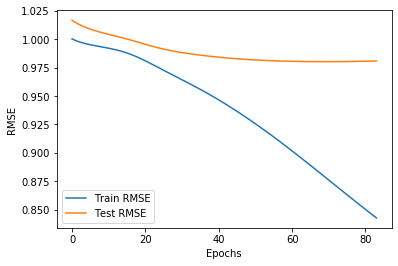

RMSE: 0.9808


In [7]:
# define the model
model = SVDPP2(sgd, get_heuristics, n_factors=192, n_epochs=85, init_mean=0.2, init_std=0.001, lr0_P=0.005, lr0_Q=0.005, alpha_P=0.3, alpha_Q=0.3, decay_P=0.02, decay_Q=0.05, reg_P=0.06, reg_Q=0.065, lambda_1=0.5, lambda_2=25, lambda_3=35)

# fit the model to the training set
model.fit(trainset)

# compute the predictions
predictions = model.test(testset)

# compute the RMSE on the testset
rmse = accuracy.rmse(predictions)